In [13]:
import pandas as pd
import numpy as np
data = pd.read_csv(r"C:\Users\paula\OneDrive\Documents\Financial Modelling Package\raw_data.csv", sep = ";")

The corrected SVI model fit with the maturity

In [14]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

def svi_total_variance(k, a, b, rho, m, sigma):
    """
    Classic SVI formula for *total implied variance* w(k):
        w(k) = a + b * [ rho*(k - m) + sqrt((k - m)**2 + sigma**2) ]
    """
    return a + b * (rho*(k - m) + np.sqrt((k - m)**2 + sigma**2))

class SVIModel:
    def __init__(self):
        """
        We'll store a dictionary of {maturity: (a, b, rho, m, sigma)}.
        """
        self.params_by_maturity = {}
        
    def fit(self, df, 
            log_moneyness_col='Log_Moneyness',
            implied_vol_col='Implied_Volatility',
            maturity_col='Residual_Maturity'):
        """
        Fits SVI parameters *using differential evolution* to the market data.
        One fit per unique maturity T.

        Parameters
        ----------
        df : pandas.DataFrame
            Must contain columns for log-moneyness, implied volatility, maturity.
        log_moneyness_col : str
            Name of the column holding k = log-moneyness.
        implied_vol_col : str
            Name of the column holding the implied volatility.
        maturity_col : str
            Name of the column holding T (time-to-maturity in years).
        """
        
        # Group by each distinct maturity so that we do a separate 5-parameter SVI fit for each T
        grouped = df.groupby(maturity_col)
        
        for T, group_data in grouped:
            # Convert to float arrays
            k_vals = group_data[log_moneyness_col].astype(float).to_numpy()

            # If T <= 0 or too few data points, skip
            if T <= 0 or len(k_vals) < 5:
                self.params_by_maturity[T] = None
                continue

            # Convert implied vol to float, accounting for commas
            vol_vals = (group_data[implied_vol_col]
                        .astype(str)
                        .str.replace(',', '.')
                        .astype(float)
                        .to_numpy())
            # Convert implied vol to total implied variance: w = (vol^2)*T
            w_vals = (vol_vals**2) * T

            # Define the objective function for differential evolution
            def objective(params):
                a, b, rho, m, sigma = params
                w_model = svi_total_variance(k_vals, a, b, rho, m, sigma)
                residuals = w_model - w_vals
                return np.sum(residuals**2)

            # You need to pick suitable bounds for (a,b,rho,m,sigma).
            # These are just *examples*; adjust for your data range:
            #   a >= 0
            #   b >= 0
            #   rho in [-1, 1]
            #   m in [k_min-1, k_max+1] or any wide range
            #   sigma > 0
            k_min, k_max = np.min(k_vals), np.max(k_vals)
            bounds = [
                (0.0, 1.0),        # a in [0, 1]
                (1e-6, 5.0),       # b in [1e-6, 5]
                (-0.9999, 0.9999), # rho
                (k_min-1, k_max+1),# m
                (1e-6, 2.0)        # sigma
            ]

            try:
                result = differential_evolution(
                    objective,
                    bounds,
                    strategy='best1bin',
                    maxiter=1000,
                    popsize=15,
                    tol=1e-6,
                    mutation=(0.5, 1),
                    recombination=0.7,
                    seed=None,
                    polish=True,   # let it use local search at end
                    disp=False     # set True if you want progress
                )
                if result.success:
                    # best solution
                    popt = result.x
                    self.params_by_maturity[T] = popt
                else:
                    # If DE didn't converge, store None
                    self.params_by_maturity[T] = None
            except Exception as e:
                # If something goes wrong, store None or handle differently
                print(f"Error in differential evolution for T={T}: {e}")
                self.params_by_maturity[T] = None

    def predict_total_variance(self, k, T):
        """
        Return the fitted total implied variance w(k).
        """
        if T not in self.params_by_maturity or self.params_by_maturity[T] is None:
            return None
        a, b, rho, m, sigma = self.params_by_maturity[T]
        return svi_total_variance(k, a, b, rho, m, sigma)

    def predict_iv(self, k, T):
        """
        Given log-moneyness k and maturity T, return the fitted implied volatility.
          w(k) = sigma^2 * T  =>  sigma = sqrt(w(k) / T)
        """
        if T <= 0:
            return None
        w = self.predict_total_variance(k, T)
        if w is None or w < 0:
            return None
        return np.sqrt(w / T)


In [15]:
def fit_svi_slices(df,
                   log_moneyness_col="Log_Moneyness",
                   implied_vol_col="Implied_Volatility",
                   maturity_col="Residual_Maturity"):
    """
    Fits SVI parameters for *all* maturities at once using SVIModel.
    Returns the fitted model (SVIModel).
    """
    model = SVIModel()
    model.fit(df,
              log_moneyness_col=log_moneyness_col,
              implied_vol_col=implied_vol_col,
              maturity_col=maturity_col)
    return model

import matplotlib.pyplot as plt
import numpy as np

def plot_svi_slices_grid(model, df, 
                         log_moneyness_col="Log_Moneyness",
                         implied_vol_col="Implied_Volatility",
                         maturity_col="Residual_Maturity",
                         ncols=2):
    """
    Plot the data vs. SVI fits for each maturity in a grid of subplots.

    Parameters
    ----------
    model : SVIModel
        Fitted SVI model (with params_by_maturity).
    df : pd.DataFrame
        The dataframe with columns for log-moneyness, implied vol, maturity.
    log_moneyness_col : str
        Name of the column holding log-moneyness.
    implied_vol_col : str
        Name of the column holding implied vol.
    maturity_col : str
        Name of the column holding maturity (T).
    ncols : int, optional
        How many columns to use in the subplot grid. Default=2.
    """
    # Extract unique maturities
    unique_maturities = sorted(df[maturity_col].unique())
    n_mats = len(unique_maturities)

    # Figure out how many rows we need
    nrows = int(np.ceil(n_mats / float(ncols)))

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(6 * ncols, 4 * nrows))
    
    # Handle case where axes is 1D or a single object
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    elif axes.ndim == 1:
        axes = axes.reshape(-1, ncols)

    # Flatten so we can iterate easily
    axes_flat = axes.flatten()

    # Plot each maturity
    for i, T_val in enumerate(unique_maturities):
        ax = axes_flat[i]
        
        # Subset data for this T
        df_slice = df[df[maturity_col] == T_val]
        
        # Grab the arrays
        k_arr = df_slice[log_moneyness_col].astype(float).values
        iv_arr = (df_slice[implied_vol_col]
                  .astype(str)
                  .str.replace(",", ".")
                  .astype(float)
                  .values)
        
        # Scatter plot: Market data
        ax.scatter(k_arr, iv_arr,
                   color="blue", alpha=0.7,
                   label=f"Market Data (T={T_val})")

        # Plot fitted SVI curve on a k-grid
        k_min, k_max = k_arr.min() - 0.05, k_arr.max() + 0.05
        k_grid = np.linspace(k_min, k_max, 200)
        
        # Predict implied vols from the fitted model
        iv_pred = [model.predict_iv(kg, T_val) for kg in k_grid]

        ax.plot(k_grid, iv_pred, "r--", label="Fitted SVI")

        ax.set_title(f"Maturity = {T_val}")
        ax.set_xlabel("Log-Moneyness")
        ax.set_ylabel("Implied Vol")
        ax.grid(True)
        ax.legend()

    # Hide any extra subplots if #maturities < nrows*ncols
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis("off")

    plt.tight_layout()
    plt.show()



now let's fit the thing

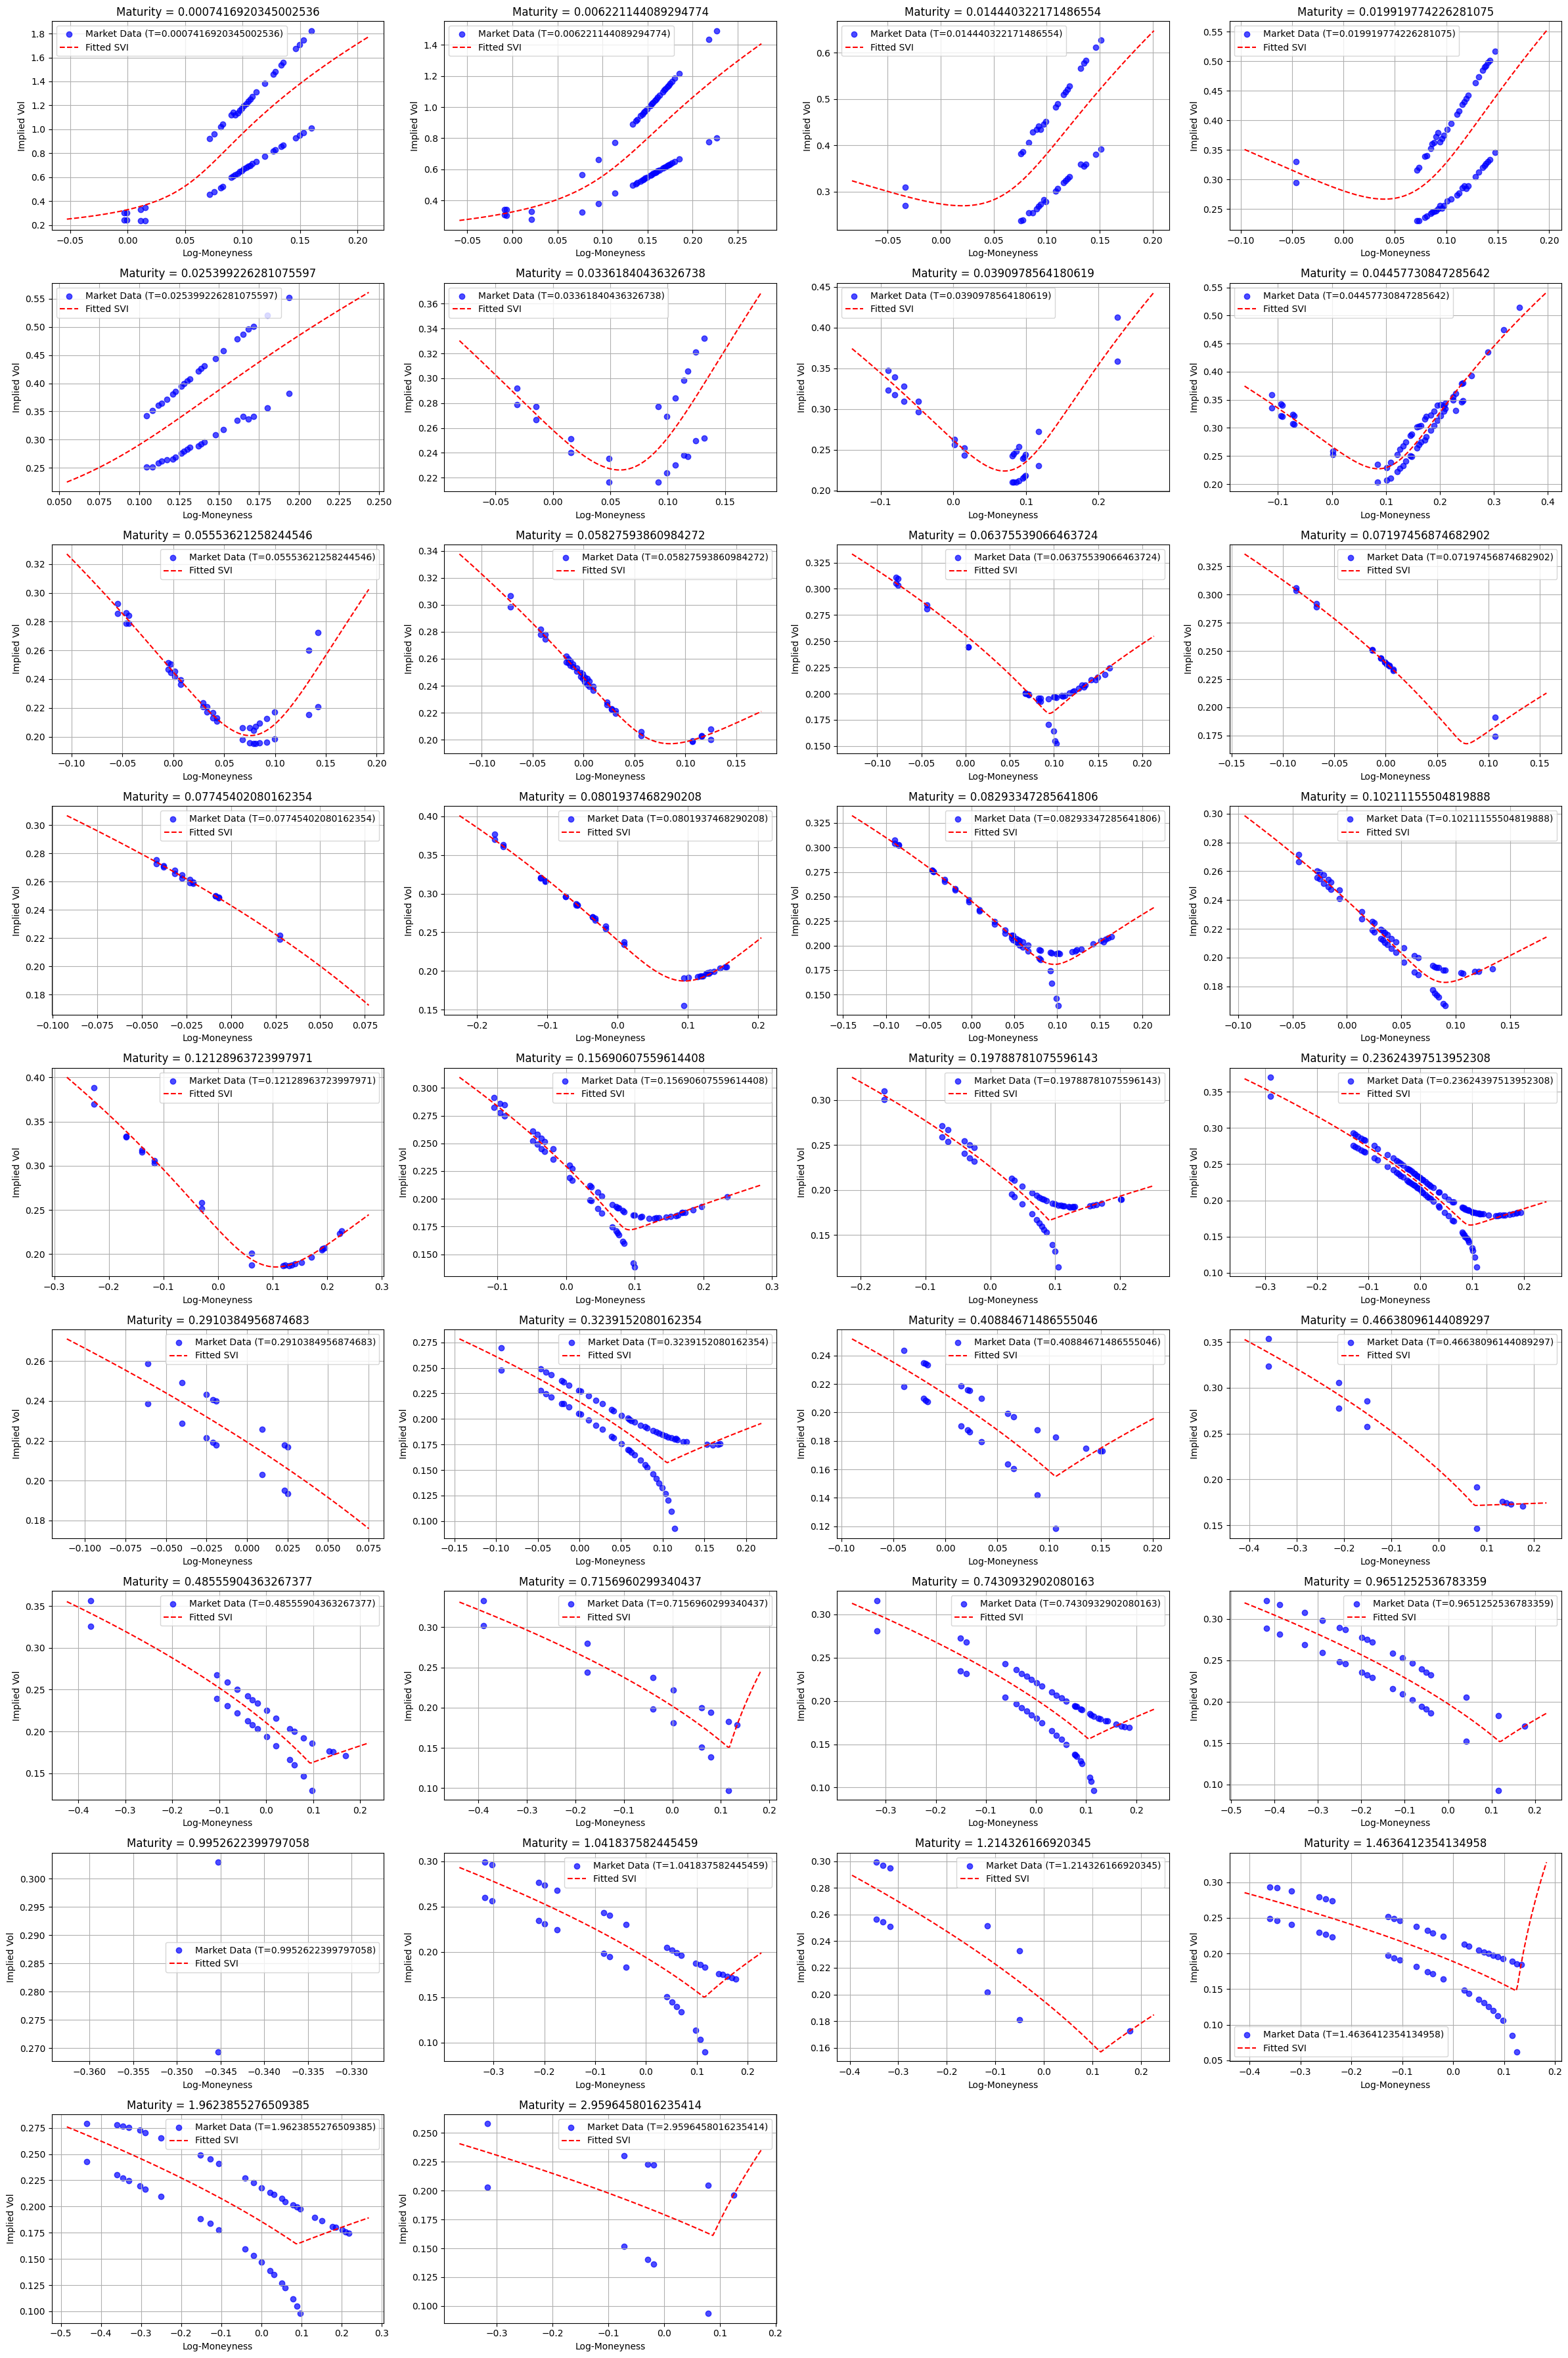

In [16]:
from financial_modelling.data_pre_processing.IVPreprocessor import IVPreprocessor
import matplotlib.pyplot as plt
displacement = 0.5
vol = (1-displacement, 1+displacement)
filtered_data = IVPreprocessor(data).preprocess(vol,vol)

# Suppose your DataFrame is 'df' with columns ["Log_Moneyness","Residual_Maturity","Implied_Volatility"].
# Fit the SVI model (all T at once)
model = fit_svi_slices(filtered_data,
                        log_moneyness_col="Log_Moneyness",
                        implied_vol_col="Implied_Volatility",
                        maturity_col="Residual_Maturity")

# Plot on a grid with 2 columns
plot_svi_slices_grid(model, filtered_data, 
                        log_moneyness_col="Log_Moneyness",
                        implied_vol_col="Implied_Volatility",
                        maturity_col="Residual_Maturity",
                        ncols=4)
